# Add objects to images

In [1]:
pip install opencv-python-headless matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 43.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import re
import random
import sys
sys.path.append(os.path.abspath('src'))
import data_preparation as dp

In [16]:
# Load the image
image_path = './IMAGES_ATTACK/10_images_original/'
image = cv2.imread(image_path)

# Parse the XML file
xml_path = './PREDICTIONS_ATTACK/10_images_original/Annotations/'

image_folder = image_path
sentence_folder = './PREDICTIONS_ATTACK/10_images_original/Sentences/'
annotation_folder = xml_path
output_folder = "./IMAGES_ATTACK/add/10_images/"
object_images_folder = "./OBJECT_IMAGES/"

In [19]:
# Get the bounding box with the "person" object which has the the maximum area
bounding_boxes_to_add = dp.process_images(image_folder, sentence_folder, annotation_folder, output_folder)

['48220', '48220', '48220', '48220', '48220']
[(158, 46, 300, 283)]
Processed 2422482455 and saved as ./IMAGES_ATTACK/add/10_images/output_2422482455.jpg
['100072', '100072', '100072', '100072', '100072', '100072']
[(249, 84, 378, 260), (47, 95, 166, 290), (122, 134, 240, 304)]
Processed 3194034449 and saved as ./IMAGES_ATTACK/add/10_images/output_3194034449.jpg
['142054', '142054', '142054', '142059', '142054', '142054']
[(211, 125, 283, 319), (80, 128, 169, 348), (296, 106, 359, 320), (347, 219, 390, 311), (443, 176, 499, 311), (324, 222, 389, 311)]
Processed 3773323977 and saved as ./IMAGES_ATTACK/add/10_images/output_3773323977.jpg
['144551', '144551', '144551', '144552', '144551', '144551']


AttributeError: 'NoneType' object has no attribute 'find'

In [6]:
# function to insert the image of an object inside the bounding box
def insert_object(image, object_images_folder, bbox):
    object_img = cv2.imread(object_images_folder)
    if object_img is None:
        print(f"Error: Image {object_images_folder} not found.")
        return

    xmin, ymin, xmax, ymax = bbox
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    insert_width = bbox_width // 2  # Cover at most 1/2 of the bounding box width
    insert_height = bbox_height // 5  # Cover at most 1/5 of the bounding box height

    # Resize insert_img to fit the bounding box 1/2 width and 1/5 height
    object_img_resized = cv2.resize(object_img, (insert_width, insert_height))

    # Insert the resized image into the topmost part of the bounding box
    insert_x_start = xmin + (bbox_width - insert_width) // 2
    image[ymin:ymin+insert_height, insert_x_start:insert_x_start+insert_width] = insert_img_resized

In [7]:
def process_images_with_inserts(image_folder, sentence_folder, annotation_folder, output_folder, object_images_folder):
    for image_filename in os.listdir(image_folder): #open the image
        if not image_filename.endswith('.jpg'):
            continue

        image_id = os.path.splitext(image_filename)[0] #take image name
        image_path = os.path.join(image_folder, image_filename)
        sentence_path = os.path.join(sentence_folder, image_id + '.txt') #find the paths
        annotation_path = os.path.join(annotation_folder, image_id + '.xml')

        if not os.path.exists(sentence_path) or not os.path.exists(annotation_path): #if there is a missing file skip this image
            print(f"Missing files for {image_id}")
            continue

        numbers = dp.extract_number_from_sentence(sentence_path) #find the number for person tag
        bboxes = dp.find_bounding_boxes(annotation_path, numbers) #find al the bounding boxes

        if not bboxes:
            print(f"No bounding boxes found for {image_id} with numbers {numbers}") #if there is not a person tag skip the image
            continue

        # Select a random object image to insert from a folder of 100 images
        object_image_path = random.choice([os.path.join(object_images_folder, f) for f in os.listdir(object_images_folder) if f.endswith('.jpg')])

        # Draw bounding boxes and insert random image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Image {image_path} not found.")
            continue

        max_bbox = max(bboxes, key=dp.calculate_area)
        insert_image(image, object_image_path, max_bbox)

        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            color = (0, 255, 0)  # Green
            thickness = 2
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)

        # Save the resulting image with bounding boxes
        output_filename = os.path.join(output_folder, f'output_{image_id}.jpg')
        cv2.imwrite(output_filename, image)
        print(f"Processed {image_id} and saved as {output_filename}")
        return image


In [8]:
image_with_object = process_images_with_inserts(image_folder, sentence_folder, annotation_folder, output_folder, object_images_folder)

['48220', '48220', '48220', '48220', '48220']
[(158, 46, 300, 283)]


IndexError: list index out of range

In [ ]:
# Visualizing the original image and the image with added objects
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with object added')
plt.imshow(cv2.cvtColor(image_with_object, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

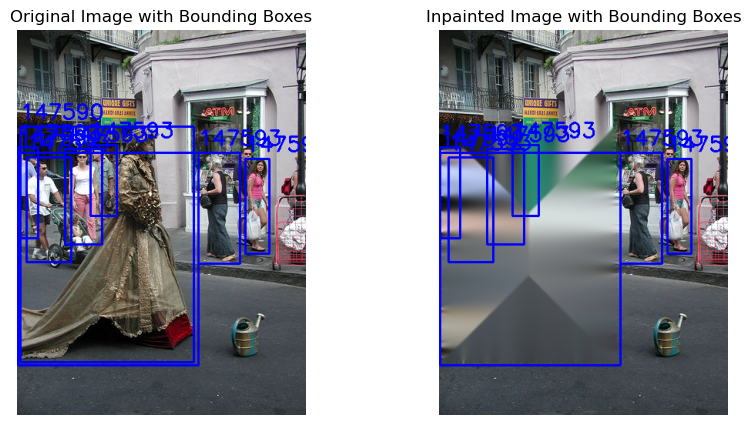

In [ ]:
# Visualize the original image and the images with added objects with bounding boxes
def draw_bounding_boxes(image, bounding_boxes, color=(255, 0, 0)):
    for (xmin, ymin, xmax, ymax, name) in bounding_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(image, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return image

original_with_boxes = draw_bounding_boxes(image.copy(), bounding_boxes)
objects_added_with_boxes = draw_bounding_boxes(image_with_object.copy(), [box for box in bounding_boxes if box not in bounding_boxes_to_add])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image with Bounding Boxes')
plt.imshow(cv2.cvtColor(original_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image with added objects with Bounding Boxes')
plt.imshow(cv2.cvtColor(objects_added_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()



In [ ]:
# Save the image with added objects and bounding boxes
output_filename = os.path.join(output_folder, f'output_{image_id}.jpg')
cv2.imwrite(output_filename, objects_added_with_boxes)
print(f"Processed {image_id} and saved as {output_filename}")